AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [1/10], Loss: 17.3449, Accuracy: 59.88%, F1: 0.4626, Precision: 0.4623, Recall: 0.4629, Duration: 2.03 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [2/10], Loss: 0.6916, Accuracy: 72.65%, F1: 0.4779, Precision: 0.5312, Recall: 0.5092, Duration: 2.05 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [3/10], Loss: 0.6502, Accuracy: 74.71%, F1: 0.4473, Precision: 0.5898, Recall: 0.5058, Duration: 2.03 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [4/10], Loss: 0.6010, Accuracy: 73.47%, F1: 0.4704, Precision: 0.5429, Recall: 0.5092, Duration: 2.02 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [5/10], Loss: 0.5798, Accuracy: 75.35%, F1: 0.4604, Precision: 0.7271, Recall: 0.5140, Duration: 2.01 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Epoch [6/10], Loss: 0.5446, Accuracy: 75.18%, F1: 0.4405, Precision: 0.8755, Recall: 0.5059, Duration: 2.04 seconds
AdaMomentum: lr=0.001, betas=(0.9, 0.999), Ep

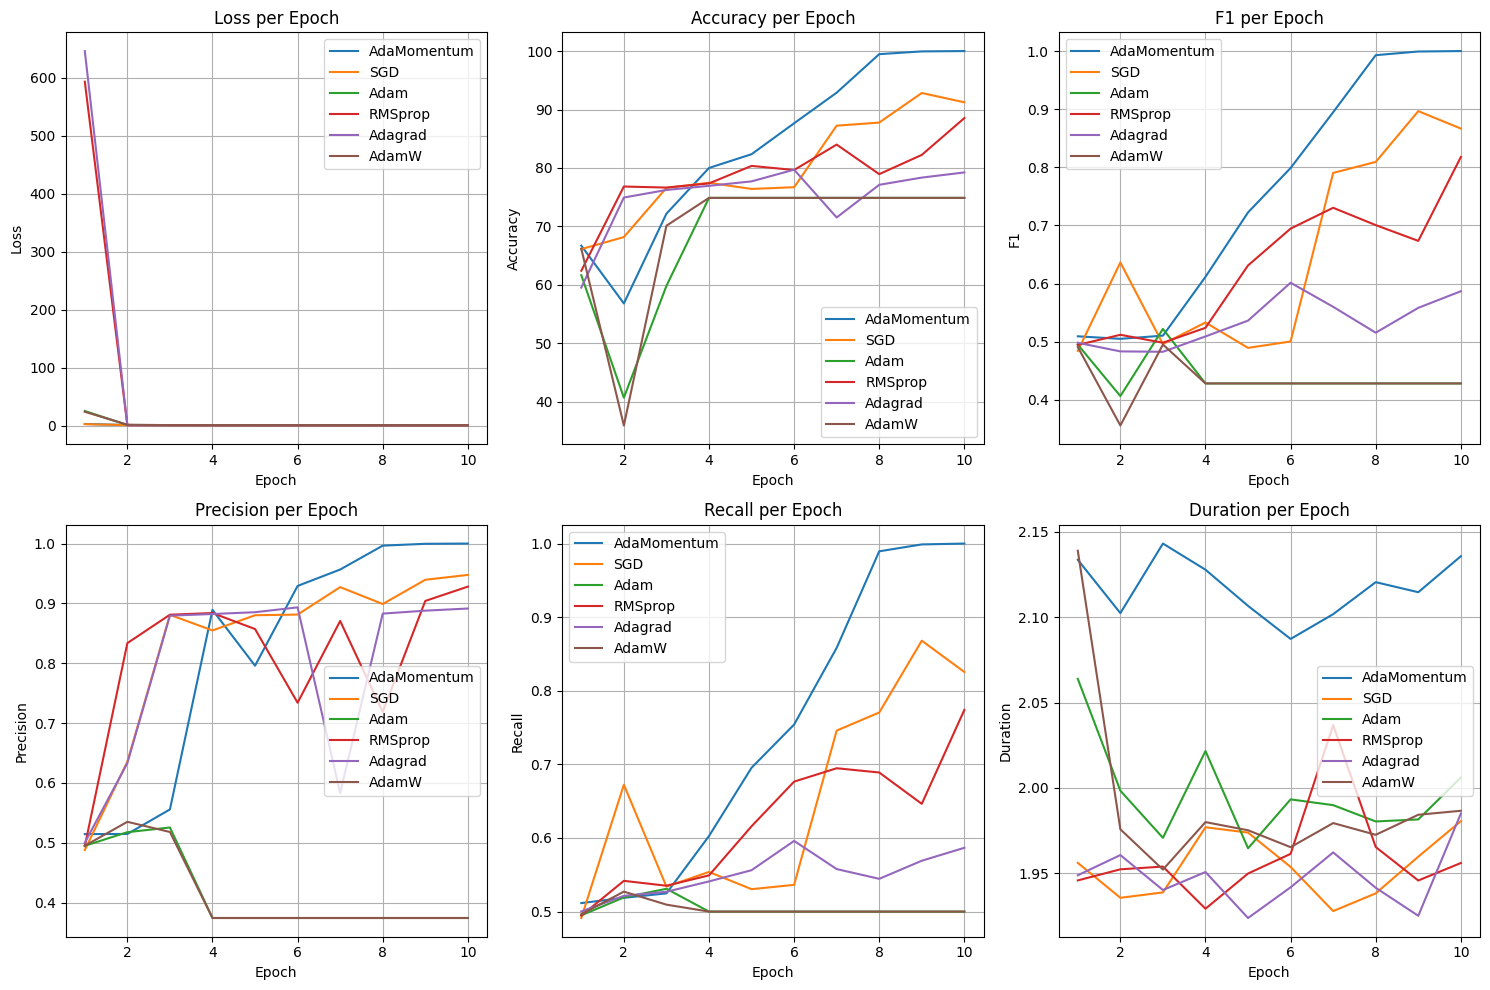

     Optimizer  Final Loss  Final Accuracy  Final F1  Final Precision  \
0  AdaMomentum    0.027295      100.000000  1.000000         1.000000   
1          SGD    0.216138       91.235294  0.866682         0.947609   
2         Adam    0.682440       74.882353  0.428187         0.374412   
3      RMSprop    0.372660       88.529412  0.817734         0.928034   
4      Adagrad    0.383113       79.235294  0.586822         0.891451   
5        AdamW    0.682732       74.882353  0.428187         0.374412   

   Final Recall  Average Duration per Epoch  
0      1.000000                    2.117349  
1      0.825527                    1.954162  
2      0.500000                    1.997060  
3      0.773997                    1.959671  
4      0.586651                    1.948007  
5      0.500000                    1.991037  


In [13]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# AdaMomentum optimizer class
class AdaMomentum(optim.Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdaMomentum, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['v_hat_prev'] = torch.zeros_like(p.data)

                m, v = state['m'], state['v']
                beta1, beta2 = group['betas']
                state['step'] += 1

                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                m_hat = m / (1 - beta1 ** state['step'])
                v_hat = v / (1 - beta2 ** state['step'])

                if state['step'] == 1:
                    eta_t = group['lr']
                else:
                    eta_t = group['lr'] * (torch.sqrt((v_hat / (state['v_hat_prev'] + group['eps'])).mean()).clamp(max=10))

                p.data.addcdiv_(m_hat, torch.sqrt(v_hat) + group['eps'], value=-eta_t)
                state['v_hat_prev'] = v_hat.clone()

        return loss

# ข้อมูลจำลองของ dataset และ model สำหรับ pose estimation
class DummyPoseEstimationDataset(Dataset):
    def __init__(self):
        self.data = torch.randn(100, 3, 224, 224)
        self.labels = torch.randint(0, 2, (100, 17, 2))  # 17 จุดสำหรับ pose estimation, 2 classes for simplicity

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class SimplePoseEstimationModel(nn.Module):
    def __init__(self):
        super(SimplePoseEstimationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Adding max pooling layer
        self.fc = nn.Linear(128 * 56 * 56, 17 * 2)  # Adjusting input size for linear layer

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.view(-1, 17, 2)

# การเตรียม dataset และ dataloader
dataset = DummyPoseEstimationDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# การเตรียมโมเดล
model = SimplePoseEstimationModel()

# การเตรียม loss function
criterion = nn.CrossEntropyLoss()

# ปรับค่า hyperparameters ของ AdaMomentum
learning_rates = [0.001, 0.0001, 0.00001]
betas_list = [(0.9, 0.999), (0.9, 0.9), (0.8, 0.888)]

best_loss = float('inf')
best_params = None

for lr in learning_rates:
    for betas in betas_list:
        optimizer = AdaMomentum(model.parameters(), lr=lr, betas=betas, eps=1e-8, weight_decay=0)
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)  # Reset model parameters
        epoch_stats = {'loss': [], 'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'duration': []}
        
        for epoch in range(10):  # Reduced to 10 epochs for hyperparameter tuning
            model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            start_time = time.time()

            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1, 2).max(1)[1])
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                preds = outputs.argmax(dim=-1).view(-1).cpu().numpy()
                labels = labels.view(-1, 2).max(1)[1].cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels)

            duration = time.time() - start_time
            avg_loss = running_loss / len(dataloader)
            accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
            f1 = f1_score(all_labels, all_preds, average='macro')
            precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
            recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

            epoch_stats['loss'].append(avg_loss)
            epoch_stats['accuracy'].append(accuracy)
            epoch_stats['f1'].append(f1)
            epoch_stats['precision'].append(precision)
            epoch_stats['recall'].append(recall)
            epoch_stats['duration'].append(duration)

            print(f'AdaMomentum: lr={lr}, betas={betas}, Epoch [{epoch+1}/10], Loss: {avg_loss:.4f}, '
                  f'Accuracy: {accuracy:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, '
                  f'Duration: {duration:.2f} seconds')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = (lr, betas)

print(f'Best AdaMomentum parameters: lr={best_params[0]}, betas={best_params[1]}, Loss={best_loss:.4f}')

# การเปรียบเทียบ Optimizers
optimizers = {
    'AdaMomentum': AdaMomentum(model.parameters(), lr=best_params[0], betas=best_params[1], eps=1e-8, weight_decay=0),
    'SGD': optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    'Adam': optim.Adam(model.parameters(), lr=0.001),
    'RMSprop': optim.RMSprop(model.parameters(), lr=0.001),
    'Adagrad': optim.Adagrad(model.parameters(), lr=0.01),
    'AdamW': optim.AdamW(model.parameters(), lr=0.001)
}

# การฝึกฝนโมเดลและเก็บค่า loss, accuracy, f1, precision, recall
num_epochs = 10
results = {}

for opt_name, optimizer in optimizers.items():
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)  # Reset model parameters
    epoch_stats = {'loss': [], 'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'duration': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        start_time = time.time()

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 2), labels.view(-1, 2).max(1)[1])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = outputs.argmax(dim=-1).view(-1).cpu().numpy()
            labels = labels.view(-1, 2).max(1)[1].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

        duration = time.time() - start_time
        avg_loss = running_loss / len(dataloader)
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
        f1 = f1_score(all_labels, all_preds, average='macro')
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        epoch_stats['loss'].append(avg_loss)
        epoch_stats['accuracy'].append(accuracy)
        epoch_stats['f1'].append(f1)
        epoch_stats['precision'].append(precision)
        epoch_stats['recall'].append(recall)
        epoch_stats['duration'].append(duration)

        print(f'Optimizer: {opt_name}, Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, '
              f'Duration: {duration:.2f} seconds')

    results[opt_name] = epoch_stats

# การแสดงผลลัพธ์
metrics = ['loss', 'accuracy', 'f1', 'precision', 'recall', 'duration']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    for opt_name, stats in results.items():
        plt.plot(range(1, num_epochs+1), stats[metric], label=opt_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} per Epoch')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# สรุปผลลัพธ์ในรูปแบบตาราง
summary = {
    'Optimizer': [],
    'Final Loss': [],
    'Final Accuracy': [],
    'Final F1': [],
    'Final Precision': [],
    'Final Recall': [],
    'Average Duration per Epoch': []
}

for opt_name, stats in results.items():
    summary['Optimizer'].append(opt_name)
    summary['Final Loss'].append(stats['loss'][-1])
    summary['Final Accuracy'].append(stats['accuracy'][-1])
    summary['Final F1'].append(stats['f1'][-1])
    summary['Final Precision'].append(stats['precision'][-1])
    summary['Final Recall'].append(stats['recall'][-1])
    summary['Average Duration per Epoch'].append(np.mean(stats['duration']))

summary_df = pd.DataFrame(summary)
print(summary_df)